<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/00_STL_Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 분해법(Decomposition Method)

# 전체 아이디어

* **가정(로그-가법 모형)**

  $$\log y_t ;=; T_t ;+; S_t ;+; R_t$$
  
  월별 로그가격을 **추세 (T_t)**, **계절성 (S_t)**, **잔차 (R_t)**로 STL로 분해하고,

  * $(T_t)$: 간단히 **선형회귀로 직선 외삽**
  * $(S_t)$: **마지막 1년(12개월) 패턴을 반복**(seasonal-naive)
  * $(R_t)$: 보수적으로 **0**(평균)으로 둠
      
   합쳐서 $$\hat{\log y}*{t+h}=\hat T*{t+h}+\hat S_{t+h}$$ → **지수변환**으로 가격 예측.

왜 로그? 주가처럼 **곱셈적 계절성/변동성 불균등**을 완화하고, **STL(가법)**과 잘 맞춰주기 위해서.


# 코드 흐름

## 1) 데이터 준비

* `yfinance`에서 **조정종가**를 가져와 **월말(M)**로 리샘플.
* `y_log = log(price)` (이름 충돌 오류 방지를 위해 `y_log.name`으로 이름 지정).

## 2) STL 분해

```python
stl = STL(y_log, period=12, robust=True)
res = stl.fit()
trend, seasonal, resid = res.trend, res.seasonal, res.resid
```

* **period=12**: 월데이터의 연간 계절성.
* **robust=True**: 이상치의 영향 완화.



[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-267526713.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  px_m = px.resample(freq).last().dropna()


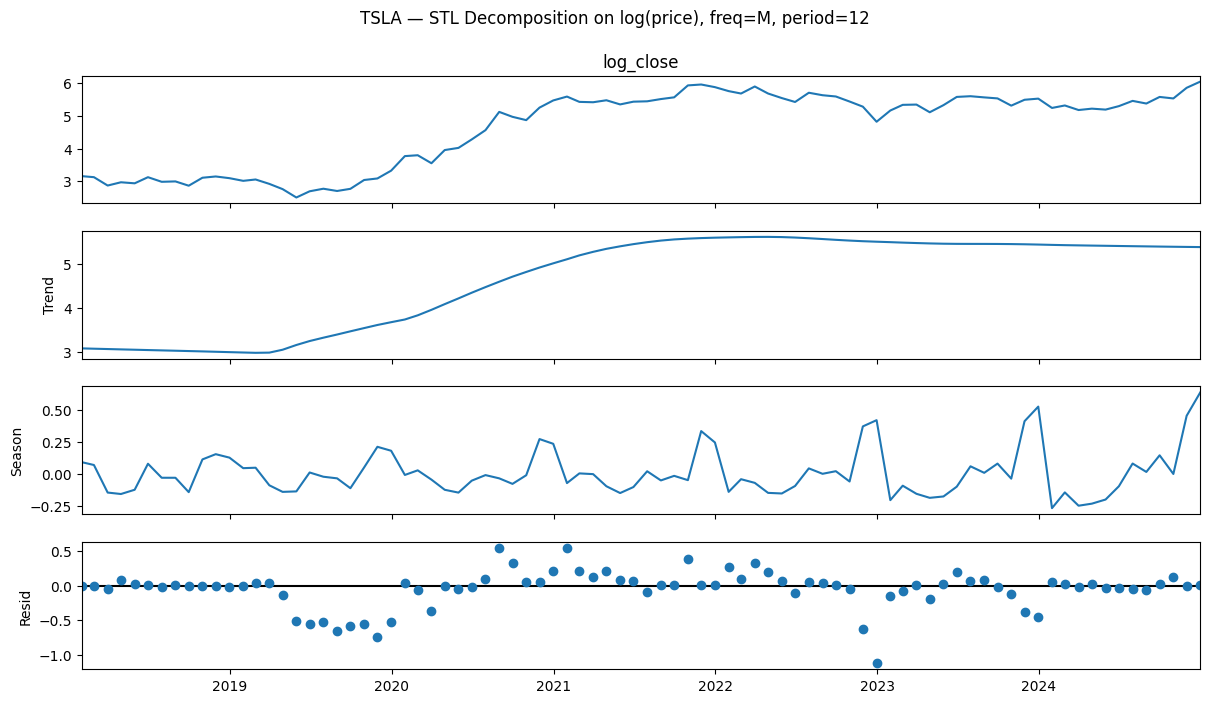

In [1]:
# %pip -q install yfinance statsmodels scikit-learn

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.seasonal import STL

plt.rcParams["figure.figsize"] = (12, 5)

symbol     = "TSLA"
start_date = "2018-01-01"
end_date   = "2024-12-31"

px = yf.download(symbol, start=start_date, end=end_date, auto_adjust=True)[["Close"]].dropna()
px.index = pd.to_datetime(px.index)

# 월말 리샘플
freq   = "M"
period = 12
px_m = px.resample(freq).last().dropna()

# 🔧 여기만 바꿨습니다
y_log = np.log(px_m["Close"].astype(float))
y_log.name = "log_close"

# STL 분해
stl = STL(y_log, period=period, robust=True)
res = stl.fit()
trend, seasonal, resid = res.trend, res.seasonal, res.resid

fig = res.plot(); fig.set_size_inches(12, 7)
plt.suptitle(f"{symbol} — STL Decomposition on log(price), freq={freq}, period={period}", y=1.02)
plt.show()




## 3) 학습/테스트 분리(80/20)

* 월 단위 시계열을 시간순으로 분리해서 **데이터 누수 방지**.

## 4) 구성요소 예측

* **추세 (T)**: `LinearRegression`으로 직선 적합 → 미래 (h)개월 외삽.
* **계절 (S)**: 마지막 12개월 값을 **차례로 반복**.
  시작 월을 맞추기 위해 `start_pos = (마지막 학습월 + 1) % 12`.
* **잔차 (R)**: 0으로 둠(간단 기준). *고도화 시 ARIMA/ETS로 모델링 가능.*

## 5) 합성·역변환·평가

* $(\hat{\log y})$ = 추세 + 계절 → `np.exp`로 **가격**으로 복원.
* 테스트 구간에서 **RMSE / MAE / R²** 계산.
* 실제 vs 예측 **오버레이 플롯** 및 **STL 구성요소 플롯** 출력.



[Decomposition forecast] RMSE=605.8435 | MAE=556.4586 | R2=-98.1023


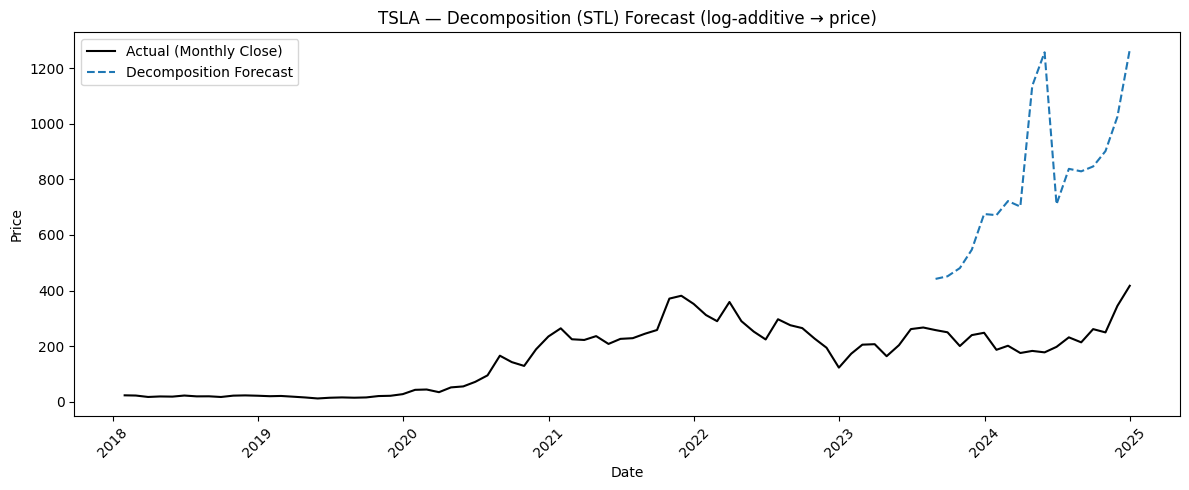

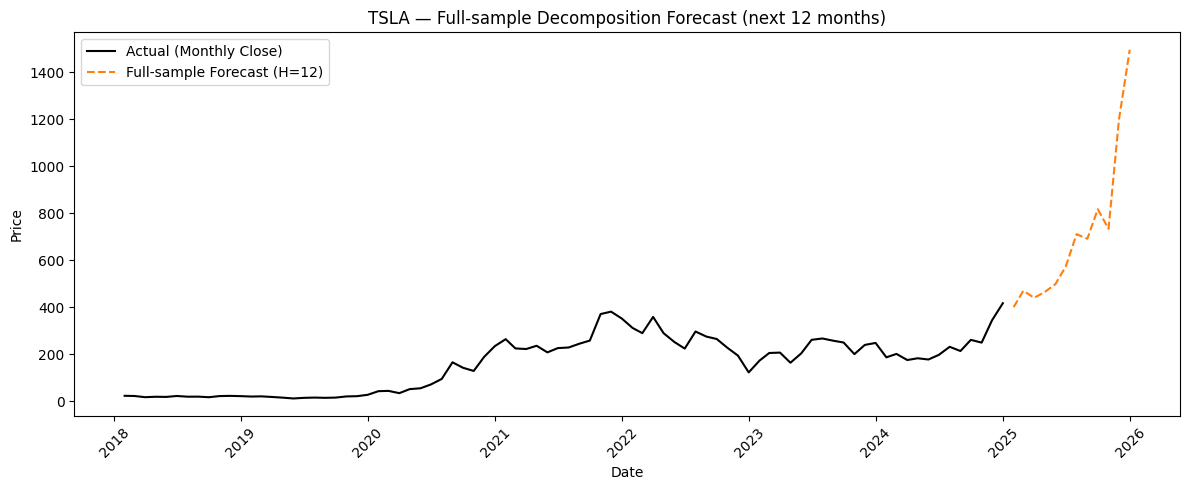

In [6]:
# -----------------------------
# 3) 학습/테스트 분할 (80/20)
# -----------------------------
n = len(y_log)
split = int(n * 0.8)
y_train, y_test = y_log.iloc[:split], y_log.iloc[split:]
trend_train, seasonal_train = trend.iloc[:split], seasonal.iloc[:split]

dates_train = y_train.index
dates_test  = y_test.index

# -----------------------------
# 4) 간단한 예측 전략
# (a) 추세: 선형회귀로 추세 성분 외삽
# (b) 계절성: 학습 구간의 마지막 'period' 패턴 반복
# 잔차는 평균 0 가정
# -----------------------------

def forecast_trend_linear(trend_series, h):
    """추세 성분을 선형회귀로 외삽."""
    t = np.arange(len(trend_series)).reshape(-1, 1)
    lr = LinearRegression().fit(t, trend_series.values)
    t_future = np.arange(len(trend_series), len(trend_series) + h).reshape(-1, 1)
    return lr.predict(t_future)

def repeat_last_season(seasonal_series, period, h, start_idx=0):
    """
    마지막 'period' 계절 패턴을 그대로 반복.
    start_idx=0이면 바로 다음 스텝부터 pattern[0]이 배치됨.
    """
    if len(seasonal_series) < period:
        # 데이터가 짧으면 평균치로 대체
        return np.full(h, seasonal_series.mean(), dtype=float)
    last = seasonal_series.values[-period:]
    out = np.empty(h, dtype=float)
    for i in range(h):
        out[i] = last[(start_idx + i) % period]
    return out

# 테스트 구간 길이
h = len(y_test)

# (a) 추세 예측
trend_fcst = forecast_trend_linear(trend_train, h)

# (b) 계절 예측 (달력 정렬: 테스트 시작 달의 "계절 포지션" 맞추기)
# 학습 구간의 마지막 인덱스가 season의 어디였는지 계산
# 월별(period=12) 가정: 월 번호를 써서 정렬
def month_pos(idx): return idx.month - 1  # 0..11
start_pos = (month_pos(dates_train[-1]) + 1) % period
season_fcst = repeat_last_season(seasonal_train, period, h, start_idx=start_pos)

# (c) 로그 예측 = 추세 + 계절 (+ 잔차 0)
log_fcst = trend_fcst + season_fcst

# (d) 원단위(가격)로 복원
price_test = px_m["Close"].iloc[split:]
price_fcst = np.exp(log_fcst)

# -----------------------------
# 5) 성능 평가 & 시각화
# -----------------------------
rmse = np.sqrt(mean_squared_error(price_test.values, price_fcst))
mae  = mean_absolute_error(price_test.values, price_fcst)
r2   = r2_score(price_test.values, price_fcst)
print(f"[Decomposition forecast] RMSE={rmse:.4f} | MAE={mae:.4f} | R2={r2:.4f}")

plt.figure(figsize=(12,5))
plt.plot(px_m.index, px_m["Close"], label="Actual (Monthly Close)", color="black")
plt.plot(dates_test, price_fcst, label="Decomposition Forecast", linestyle="--", color="tab:blue")
plt.title(f"{symbol} — Decomposition (STL) Forecast (log-additive → price)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# 6) Full-sample 최종 적합 → 미래 H개월 예측
# -----------------------------
H = 12  # 예: 12개월
stl_full = STL(y_log, period=period, robust=True).fit()
trend_full, seasonal_full = stl_full.trend, stl_full.seasonal

trend_future  = forecast_trend_linear(trend_full, H)

# 미래 시작 달(학습 마지막 달 다음달)의 계절 포지션
start_pos_full = (month_pos(y_log.index[-1]) + 1) % period
season_future = repeat_last_season(seasonal_full, period, H, start_idx=start_pos_full)

log_future = trend_future + season_future
price_future = np.exp(log_future)

future_idx = pd.date_range(y_log.index[-1] + pd.offsets.MonthEnd(1), periods=H, freq="ME")

plt.figure(figsize=(12,5))
plt.plot(px_m.index, px_m["Close"], label="Actual (Monthly Close)", color="black")
plt.plot(future_idx, price_future, label=f"Full-sample Forecast (H={H})", linestyle="--", color="tab:orange")
plt.title(f"{symbol} — Full-sample Decomposition Forecast (next {H} months)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()



# 핵심 함수(요지)

* `forecast_trend_linear`: 추세에 **직선**을 적합해 미래 $(h)$ 스텝 예측.
* `repeat_last_season`: 마지막 **12개월 계절패턴**을 그대로 반복.
* (선택) 잔차를 따로 모델링하면 정밀도가 더 좋아질 수 있어요.



# 자주 묻는 질문(FAQ)

**Q1. 계절성이 약한 주가에도 유효한가요?**

* 강한 ‘캘린더’ 패턴이 없을 수 있어 성능이 제한될 수 있습니다. 그럴 땐 **STL의 trend만 쓰고 seasonal은 0**으로 두거나, **잔차에 ARIMA/SARIMA**를 얹어 보세요.

**Q2. 일봉으로 하고 싶다면?**

* `period=5`(주중 거래일), 또는 `B`(영업일) 기준. 다만 휴장/이벤트로 주기성이 흔들릴 수 있어 월/주 리샘플이 안정적입니다.

**Q3. 왜 로그인가요?**

* **변동성 안정화**와 **곱셈적 계절성 → 가법화** 효과. 예측 후 `exp`로 되돌립니다.

**Q4. 단순 반복 대신 더 똑똑한 계절 예측은?**

* 최근 몇 년의 같은 달 평균, Holt-Winters(ETS)의 계절 성분, 또는 TBATS/Prophet 같은 방법으로 대체 가능합니다.



# 확장 아이디어

* **Fixed-origin / Rolling / Expanding** 백테스트로 평가(원점 이동).
* 잔차 $(R_t)$를 ARIMA/SARIMA로 예측해 $(\hat{T}+\hat{S}+\hat{R})$ 구성.
* **비선형 추세**$(spline/LOESS)$ 외삽, **Regressor**(거래량, 금리 등) 추가.

# 순환변동 포함 요소분해

##  옵션 1) 구조적 시계열(상태공간) – Unobserved Components의 cycle 사용
statsmodels의 UCM은 cycle 성분을 내장하고 있어 STL보다 자연스럽게 순환을 다룸

In [9]:
# ============================================
# Colab 준비 (필요 시)
# ============================================
# %pip -q install yfinance statsmodels scikit-learn

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.ar_model import AutoReg

plt.rcParams["figure.figsize"] = (12, 5)

# ============================================
# 1) 데이터 로드 → 월말 종가 → 로그 변환
# ============================================
symbol     = "TSLA"
start_date = "2016-01-01"
end_date   = "2024-12-31"

# auto_adjust=True: 배당/액면 등 조정반영
px_d = yf.download(symbol, start=start_date, end=end_date, auto_adjust=True)[["Close"]].dropna()
px_d.index = pd.to_datetime(px_d.index)

# 월말(MonthEnd)로 집계: 마지막 영업일 종가
px_m = px_d.resample("ME").last().dropna()

# ✅ 항상 Series로 강제(squeeze) → 이름 설정 후 로그
close_s = px_m["Close"]
if isinstance(close_s, pd.DataFrame):   # 1열 DF로 오는 경우 방지
    close_s = close_s.squeeze("columns")
close_s = pd.to_numeric(close_s, errors="coerce").dropna()
close_s.name = "close"

y_log = np.log(close_s)
y_log.name = "log_close"

dates = y_log.index
print(f"{symbol}: {len(y_log)} monthly obs | {dates[0].date()} ~ {dates[-1].date()}")


# 예측 길이 (개월)
H = 12

[*********************100%***********************]  1 of 1 completed

TSLA: 108 monthly obs | 2016-01-31 ~ 2024-12-31


                            Unobserved Components Results                            
Dep. Variable:                     log_close   No. Observations:                  108
Model:                    local linear trend   Log Likelihood                  15.522
                   + stochastic seasonal(12)   AIC                            -17.044
                   + damped stochastic cycle   BIC                              0.684
Date:                       Wed, 08 Oct 2025   HQIC                            -9.886
Time:                               10:01:10                                         
Sample:                           01-31-2016                                         
                                - 12-31-2024                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

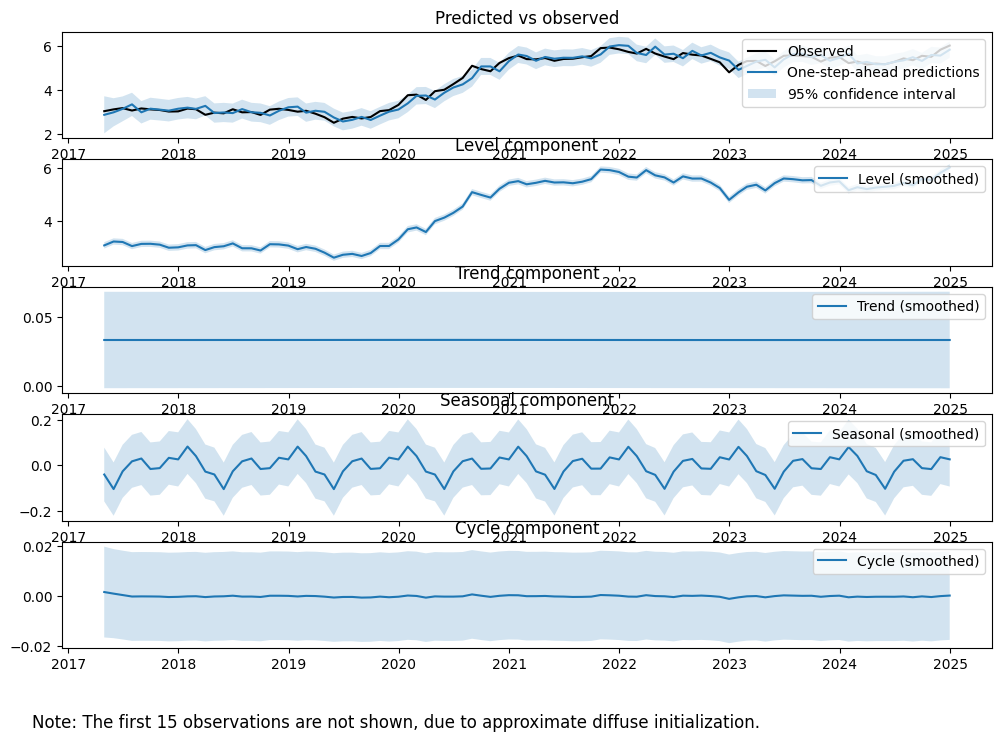

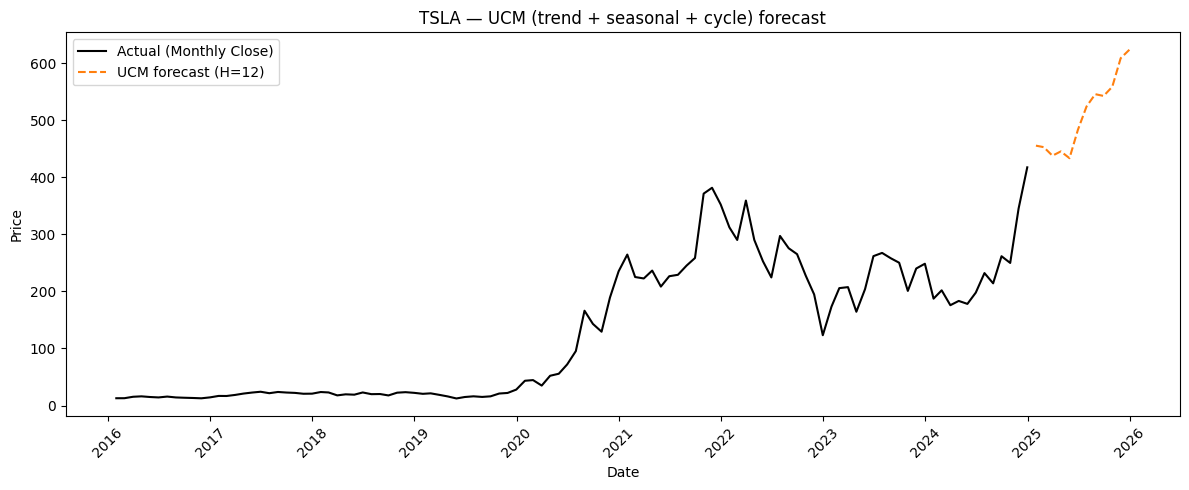

In [10]:
# ============================================
# 2) Unobserved Components (UCM): level + seasonal(12) + cycle
# ============================================
ucm = UnobservedComponents(
    y_log,
    level="local linear trend",   # 로컬 선형추세
    seasonal=12,                  # 월별 계절성
    cycle=True,                   # 순환 성분
    damped_cycle=True,            # 감쇠 허용
    stochastic_cycle=True         # 확률적 순환
)
res_ucm = ucm.fit(disp=False)

print(res_ucm.summary())

# (선택) 구성요소 시각화
res_ucm.plot_components(legend_loc="upper right", figsize=(12, 8));

# 성분 시계열 추출(가능한 경우)
def get_ucm_components(res, index):
    comps = {}
    for name in ["level", "trend", "seasonal", "cycle"]:
        attr = f"{name}_smoothed"
        if hasattr(res, attr):
            arr = getattr(res, attr)
            comps[name] = pd.Series(np.asarray(arr).ravel(), index=index, name=name)
    return comps

ucm_comps = get_ucm_components(res_ucm, y_log.index)

# UCM 예측 (H개월)
pred_ucm = res_ucm.get_forecast(steps=H)
log_future_ucm = pred_ucm.predicted_mean
price_future_ucm = np.exp(log_future_ucm)

future_idx = pd.date_range(y_log.index[-1] + pd.offsets.MonthEnd(1), periods=H, freq="ME")

plt.figure()
plt.plot(px_m.index, px_m["Close"], label="Actual (Monthly Close)", color="black")
plt.plot(future_idx, price_future_ucm, label=f"UCM forecast (H={H})", linestyle="--", color="tab:orange")
plt.title(f"{symbol} — UCM (trend + seasonal + cycle) forecast")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()


## 옵션 2) STL + HP 필터(또는 밴드패스)로 순환만 추가 분리

STL로 추세+계절을 뺀 뒤, 남은 부분에서 장주기 성분만 따로 추출합니다.

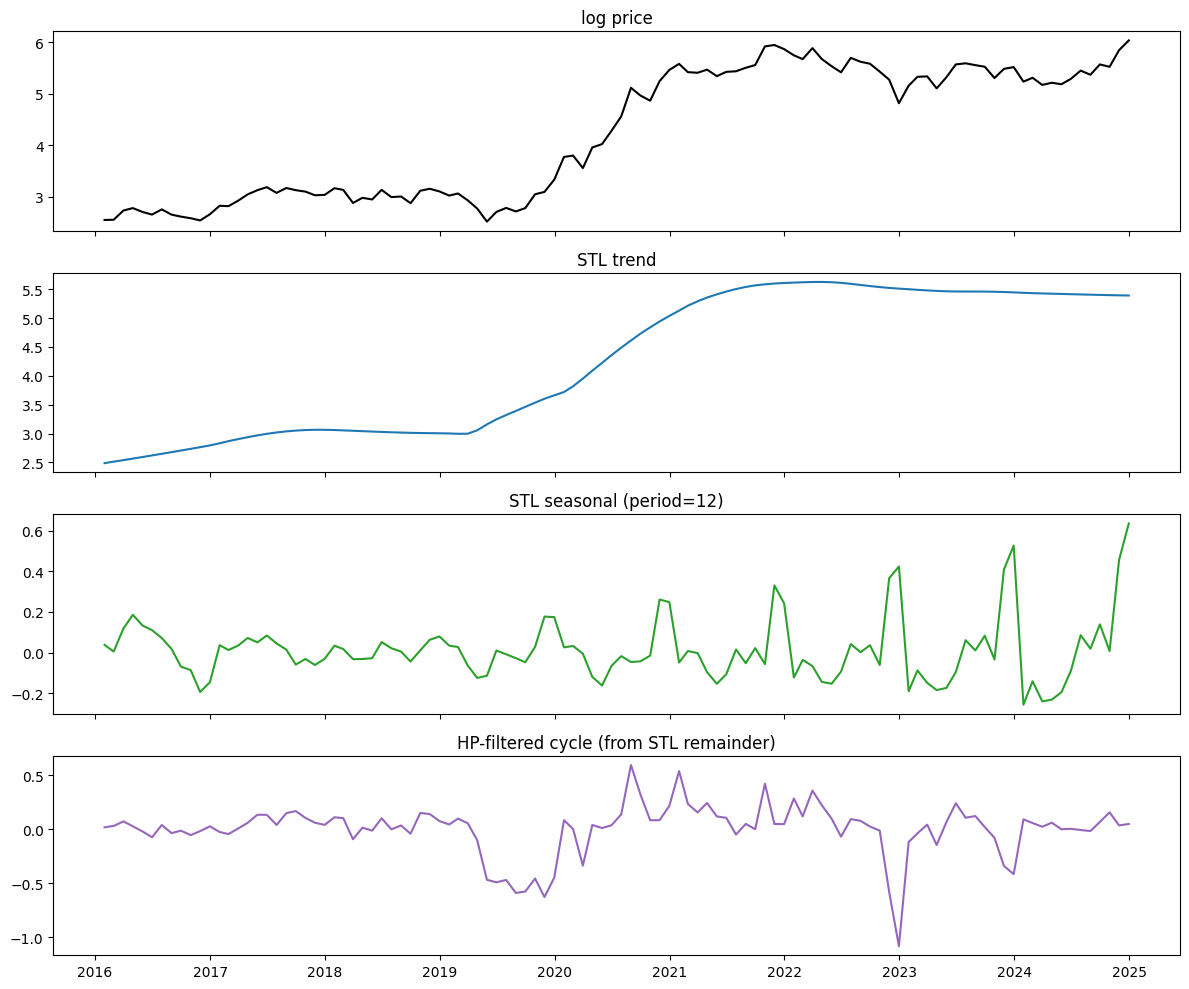

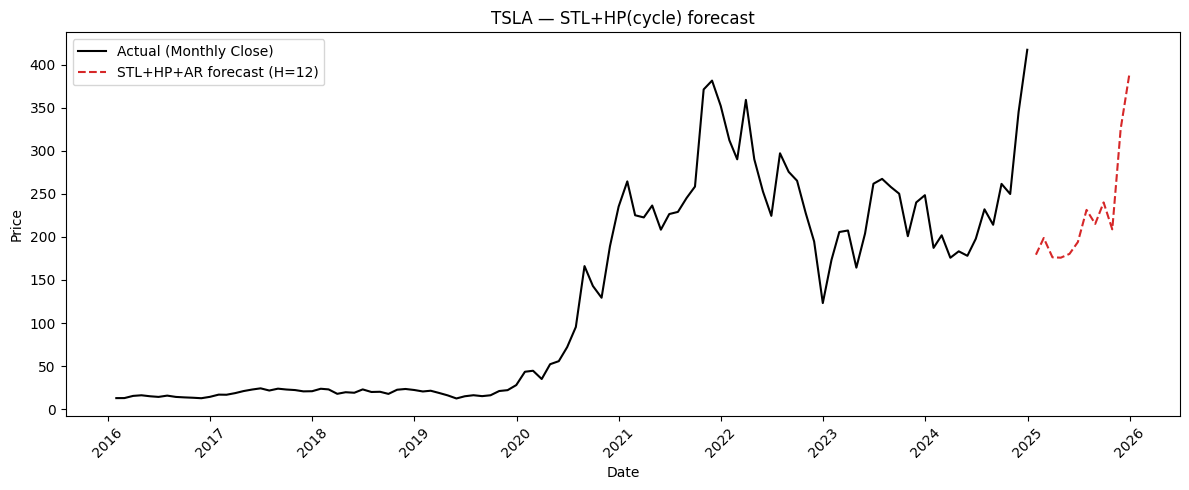

In [12]:
# ============================================
# 3) STL 분해 (additive on log) → remainder에서 HP필터로 'cycle' 추출
# ============================================
stl = STL(y_log, period=12, robust=True)
stl_res = stl.fit()
trend_stl = stl_res.trend
season_stl = stl_res.seasonal
rem_stl = y_log - trend_stl - season_stl

# HP 필터: 월별 람다 ≈ 129600 권장
cycle_hp, trend_hp = hpfilter(rem_stl, lamb=129600)

# 구성요소 플롯
fig, ax = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
ax[0].plot(y_log, color="black"); ax[0].set_title("log price")
ax[1].plot(trend_stl, color="tab:blue"); ax[1].set_title("STL trend")
ax[2].plot(season_stl, color="tab:green"); ax[2].set_title("STL seasonal (period=12)")
ax[3].plot(cycle_hp, color="tab:purple"); ax[3].set_title("HP-filtered cycle (from STL remainder)")
plt.tight_layout(); plt.show()

# ============================================
# 4) 간단 예측:
# - 추세: 직선(최근 구간) 외삽
# - 계절: '월번호'별 최근 시즌 값 반복
# - 순환: AR 모델로 H-step forecast
# ============================================
# (a) 추세 선형 외삽 (마지막 36개월로 기울기 추정)
use_n = min(24, len(trend_stl))
x = np.arange(use_n, dtype=float)
y = trend_stl.iloc[-use_n:].to_numpy(dtype=float)

coef = np.polyfit(x, y, 1)
slope = float(coef[0])
# 마지막 점의 x값은 use_n-1이므로, y_last = slope*(use_n-1) + intercept
intercept = float(trend_stl.iloc[-1]) - slope * (use_n - 1)

# 다음 H개월 트렌드 (마지막 시점 이후 1,2,...H 스텝)
trend_future = trend_stl.iloc[-1] + slope * np.arange(1, H + 1, dtype=float)
# 또는 절대 x좌표로 계산하려면:
# x_fore = np.arange(use_n, use_n + H, dtype=float)
# trend_future = slope * x_fore + intercept
# (b) 계절 반복: '월번호별' 마지막 계절값 사전 → 다음 H개월에 매핑
season_last_by_month = (
    pd.Series(season_stl.values, index=y_log.index.month)
      .groupby(level=0).last()
)
next_months = ((y_log.index[-1].month + np.arange(1, H+1) - 1) % 12) + 1
season_future = season_last_by_month.reindex(next_months).to_numpy()

# (c) 순환 예측: AutoReg(12) (월주기)
cycle_series = cycle_hp.dropna().astype(float)
lags = min(12, max(1, len(cycle_series)//10))  # 자료 길이에 따라 보수적 설정
ar_fit = AutoReg(cycle_series, lags=lags, old_names=False).fit()
cycle_future = ar_fit.forecast(H).to_numpy()

# (d) 합산 → 로그→레벨
log_future_stl = trend_future + season_future + cycle_future
price_future_stl = np.exp(log_future_stl)

plt.figure()
plt.plot(px_m.index, px_m["Close"], label="Actual (Monthly Close)", color="black")
plt.plot(future_idx, price_future_stl, label=f"STL+HP+AR forecast (H={H})", linestyle="--", color="tab:red")
plt.title(f"{symbol} — STL+HP(cycle) forecast")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()


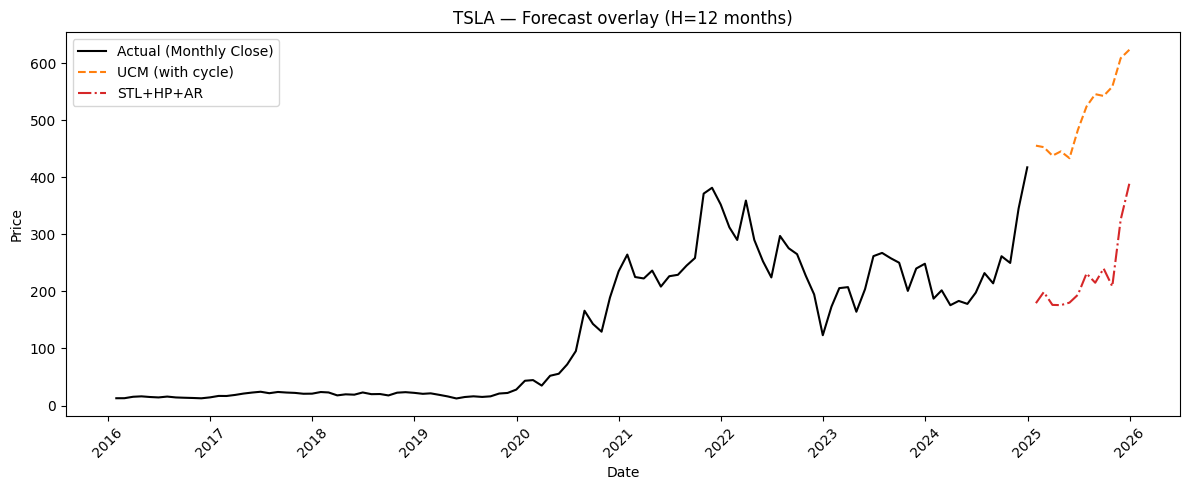

In [13]:
plt.figure()
plt.plot(px_m.index, px_m["Close"], label="Actual (Monthly Close)", color="black", linewidth=1.5)
plt.plot(future_idx, price_future_ucm, label="UCM (with cycle)", linestyle="--", color="tab:orange")
plt.plot(future_idx, price_future_stl, label="STL+HP+AR", linestyle="-.", color="tab:red")
plt.title(f"{symbol} — Forecast overlay (H={H} months)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()


# HP(Hodrick–Prescott) 필터
HP(Hodrick–Prescott) 필터는 **요소 분해(decomposition)**의 한 방법.

시계열 (Y_t)를


$$ Y_t = T_t + C_t$$


로 나누는데, 여기서

* $(T_t)$: **매끈한 장기 추세(trend)**
* $(C_t)$: **추세에서의 일시적 편차(“cycle”이라 부르지만, 꼭 주기적일 필요는 없음)**

을 뜻함.
계절성은 **포함하지 않음**(STL처럼 $(+S_t)$가 있는 구조가 아님).


# 어떻게 추세를 구하나요?

HP 필터는 “**너무 출렁이지 않는**” 추세 $(T_t)$를 찾기 위해 아래의 **벌점 최소화** 문제를 풉니다.


$$\min_{{T_t}}  \sum_{t=1}^{T} (Y_t - T_t)^2 + \lambda \sum_{t=3}^{T} \big[(T_t - T_{t-1}) - (T_{t-1} - T_{t-2})\big]^2 .$$


* 첫 항: $(Y_t)$와 추세 $(T_t)$의 **근접성**(적합도)
* 둘째 항: $(T_t)$의 **곡률(2차 차분)**에 대한 벌점 → $(T_t)$가 너무 휘지 않도록 **매끈하게** 만듭니다.
* $(\lambda)$: **스무딩 강도**. $(\lambda)$가 클수록 추세가 더 매끈(변화 둔감), 작을수록 원 자료를 더 잘 따라감.

### $(\lambda)$ 선택(관행)

* **분기 자료**: $(\lambda = 1600)$ (가장 유명)
* **월별 자료**: $(\lambda \approx 129{,}600)$
* **연간 자료**: $(\lambda \approx 6.25)$

> 위 수치는 Ravn & Uhlig(2002)의 스케일링 규칙$((\lambda \propto f^4))$을 따른 값입니다.
> 문헌에 따라 연간 100을 쓰는 예도 있으니, 데이터 성격에 맞게 튜닝하세요.



# 해석 포인트

* $(C_t = Y_t - T_t)$는 **“순환/경기변동(combined cycle)”**이라 부르지만, **정확히 주기적(sinusoidal)**일 필요는 없습니다.
  금융 시계열에서는 “**단기 변동(잔차)”**에 더 가깝게 이해되는 경우가 많아요.
* **끝점 편향(end-point bias)**: 양쪽 끝에서는 미래/과거 정보가 부족해 추세 추정이 흔들립니다.
  실시간 분석은 **일방(1-sided) HP**나 롤링 재적합을 고려하세요.
* **모형 기반이 아님**: HP는 상태공간/확률모형이 아니라 **스무딩 최적화**라서,
  **(\lambda)** 설정에 따라 모양이 꽤 달라지고, **가짜 순환(spurious cycles)** 위험도 있습니다.



# 다른 분해법과 비교

* **STL/클래식 분해**: $(Y_t = T_t + S_t + R_t)$ (추세 + 계절 + 잔차). **계절성**이 핵심.
  HP는 $(S_t)$가 없고 **추세/편차 2분해**만 함.
* **이동평균/로우패스**: 단순 스무딩. HP는 **곡률 벌점**을 통한 **최적화 기반 스무딩**.
* **칼만필터(로컬 레벨/로컬 트렌드)**: 상태공간 **확률모형**. HP는 특정 신호–잡음비를 둔 베이지안 추정과 **동치**가 성립하기도 하지만(특정 가정하), 일반적으로는 **모형 자유도**가 더 낮습니다.



# 언제 쓰나?

* **경기순환 추정(거시경제)**: 장기 추세와 단기 편차를 분리할 때 간편.
* **계절성이 약하거나 미리 제거된 데이터**에서 장기 흐름을 보고 싶을 때.
* **금융 레벨 자료**(가격)보다는 **수익률**이나 **비계절 자료**에서 안정적.



# 빠른 사용 예

**Python (statsmodels)**

```python
import pandas as pd
from statsmodels.tsa.filters.hp_filter import hpfilter

# y: pandas Series (월별이면 λ≈129600, 분기면 1600)
cycle, trend = hpfilter(y, lamb=129600)
# y = trend + cycle
```

**R (mFilter)**

```r
library(mFilter)
hp <- hpfilter(y, freq = 129600)  # monthly
trend <- hp$trend
cycle <- hp$cycle
```



# 한 줄 요약

HP 필터는 $(Y_t = T_t + C_t)$로 **추세/편차**를 가르는 **스무딩 기반 분해법**입니다.
$(\lambda)$로 추세의 매끈함을 조절하며, **계절성은 다루지 않습니다**.
끝점 편향과 ($\lambda)$ 민감도를 유념해 사용하시면 됩니다.


[*********************100%***********************]  1 of 1 completed


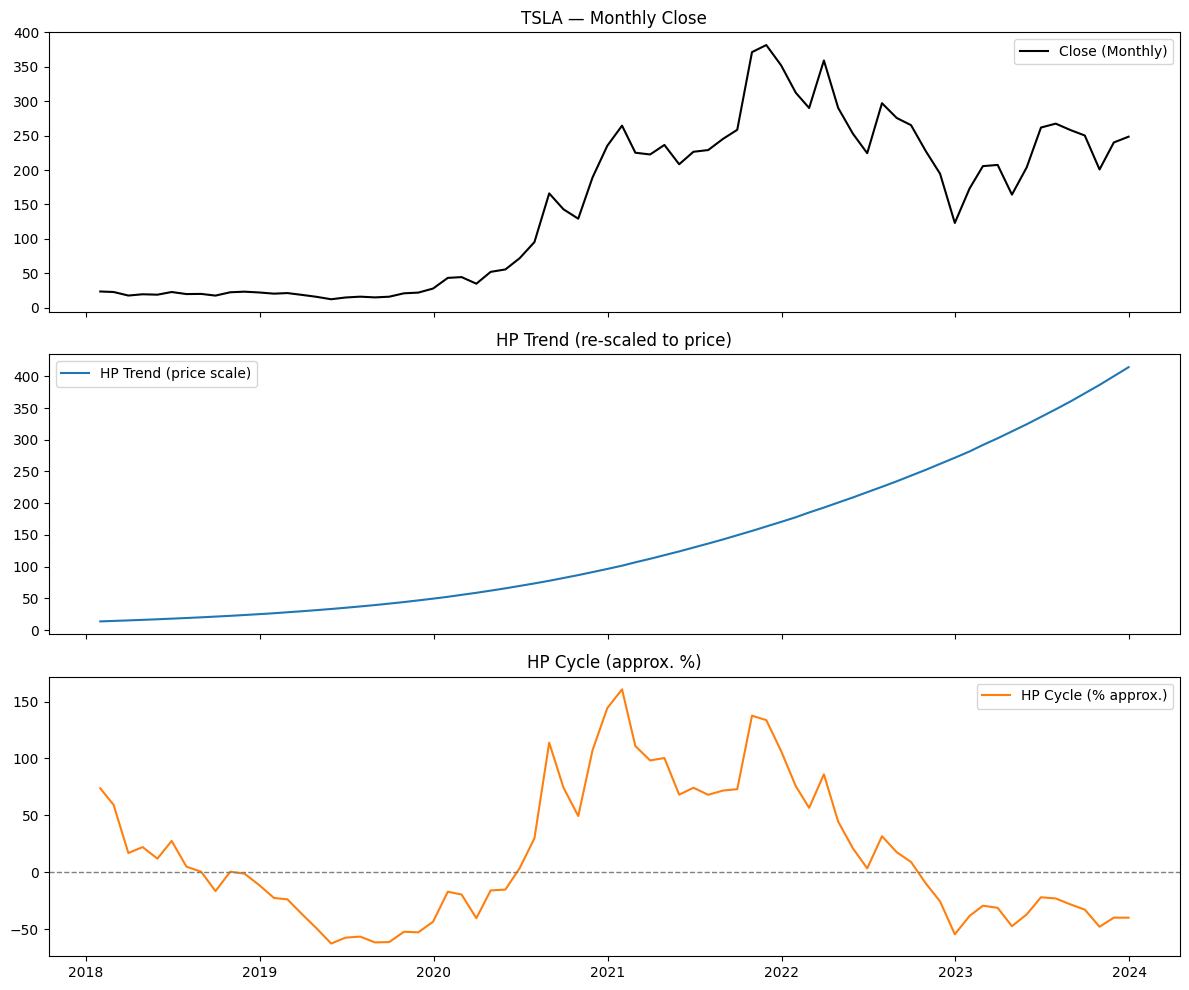

In [15]:
# ============================================
# Colab 준비 (필요할 때만)
# ============================================
# %pip -q install yfinance statsmodels matplotlib pandas

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

plt.rcParams["figure.figsize"] = (12, 5)

# ============================================
# 1) 데이터: TSLA 일별 → 월말 종가로 집계
# ============================================
symbol     = "TSLA"
start_date = "2018-01-01"
end_date   = "2024-01-01"

px_d = yf.download(symbol, start=start_date, end=end_date, auto_adjust=True)
px_d = px_d[["Close"]].dropna()

# 월말(MonthEnd) 집계 (마지막 영업일 종가)
px_m = px_d.resample("ME").last().dropna()
# ✅ 여기 고침: 이름 바꾸려면 name 속성으로!
y = px_m["Close"].astype(float).copy()
y.name = "close"
y_log = np.log(y)   # HP는 가법 모형 → 로그로 변환해 '준 곱셈형' 계절/변동을 가법화

# ============================================
# 2) HP 필터 분해 (월별 λ=129,600 권장)
# ============================================
LAMBDA_MONTHLY = 129_600
cycle, trend = hpfilter(y_log, lamb=LAMBDA_MONTHLY)

# 가격 스케일로 복원
trend_price = np.exp(trend)
# 순환 성분을 %로 가독화 (대략적인 근사)
cycle_pct = (np.exp(cycle) - 1.0) * 100.0

# ============================================
# 3) 시각화
# ============================================
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axes[0].plot(y.index, y.values, color="black", label="Close (Monthly)")
axes[0].set_title(f"{symbol} — Monthly Close")
axes[0].legend()

axes[1].plot(y.index, trend_price.values, color="tab:blue", label="HP Trend (price scale)")
axes[1].set_title("HP Trend (re-scaled to price)")
axes[1].legend()

axes[2].plot(y.index, cycle_pct.values, color="tab:orange", label="HP Cycle (% approx.)")
axes[2].axhline(0, color="gray", linewidth=1, linestyle="--")
axes[2].set_title("HP Cycle (approx. %)")
axes[2].legend()

plt.tight_layout()
plt.show()

# ============================================
# 4) 참고: 주별/일별 λ를 쓰고 싶다면 (비권장, 참고용)
#    λ_weekly ≈ 129,600 * (52/12)^4  ≈ 4.57e7
#    λ_daily  ≈ 129,600 * (365/12)^4 ≫ 1e10 (매우 큼)
# ============================================


# 가법(additive) vs 승법(multiplicative)

로그 변환으로 승법(multiplicative)을 가법(additive)으로 바꿈



## 핵심 원리

로그의 기본 성질 때문에

$$\log(ab)=\log a+\log b,\quad \log(abc)=\log a+\log b+\log c$$

가 됩니다.
그래서 승법 분해

$$y_t = T_t \times S_t \times R_t$$

에 로그를 취하면

$$\log y_t=\log T_t+\log S_t+\log R_t$$

처럼 **합(가법)** 형태로 바뀌죠. STL은 원래 가법 모형이므로, 로그를 취해 가법으로 만든 뒤 분해하고, 필요하면 $(\exp(\cdot))$로 다시 원척도로 돌려줍니다.

## 언제 유용한가?

* **수준이 커질수록 변동폭도 커지는**(분산이 수준 의존) 데이터: 로그로 안정화 → 승법 구조를 가법으로 변환
* **계절지수**: 승법에서는 평균이 1(로그에선 평균 0), 가법에서는 평균이 0

## 주의할 점

* **양수 자료**여야 로그 가능해요. 0이나 음수가 섞이면 작은 상수 더하기(shift)나 Box–Cox 변환을 고려합니다.
* **역변환 바이어스**: $(\mathbb{E}[\exp(X)] \neq \exp(\mathbb{E}[X]))$. 로그 스케일에서 예측 후 다시 지수로 돌릴 때, 필요하면 대략 $(\times \exp(\hat{\sigma}^2/2))$ 같은 **바이어스 보정**을 고려할 수 있어요(잔차가 정규일 때).

## 간단 예

* 승법: $(y_t = 100 \times 1.05 \times 0.98)$
* 로그: $(\log y_t = \log 100 + \log 1.05 + \log 0.98)$
  → 곱의 세계가 합의 세계로 변환됩니다.

요약하면, **“곱의 구조를 로그로 합의 구조로 바꿔서 다루기 쉽게 만든다”**가 포인트입니다.


[*********************100%***********************]  1 of 1 completed


TSLA: 130 obs | 2015-01-31 ~ 2025-10-31
[Multiplicative] 재구성 상대오차(평균 |y - T*S*R| / y): nan%


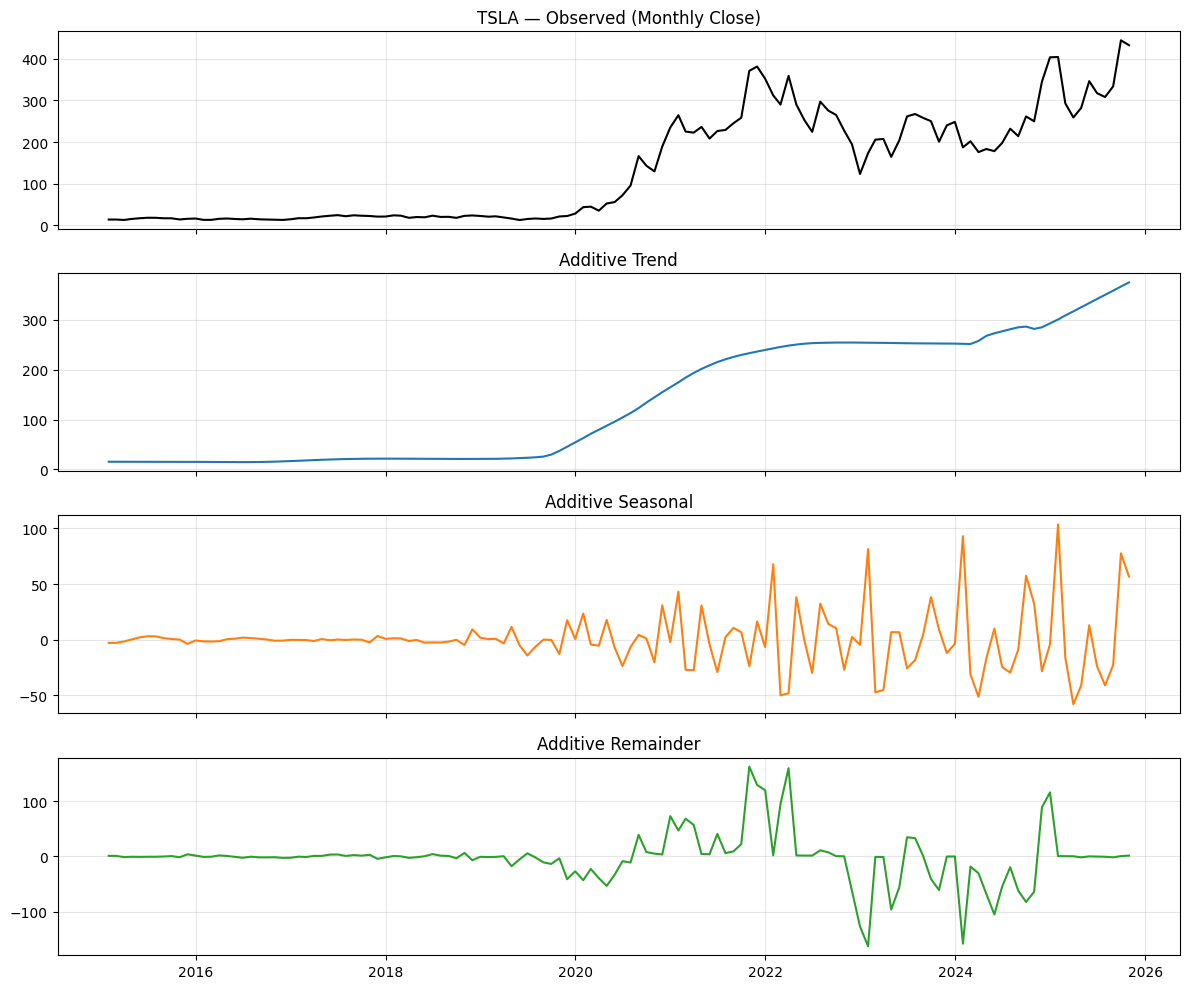

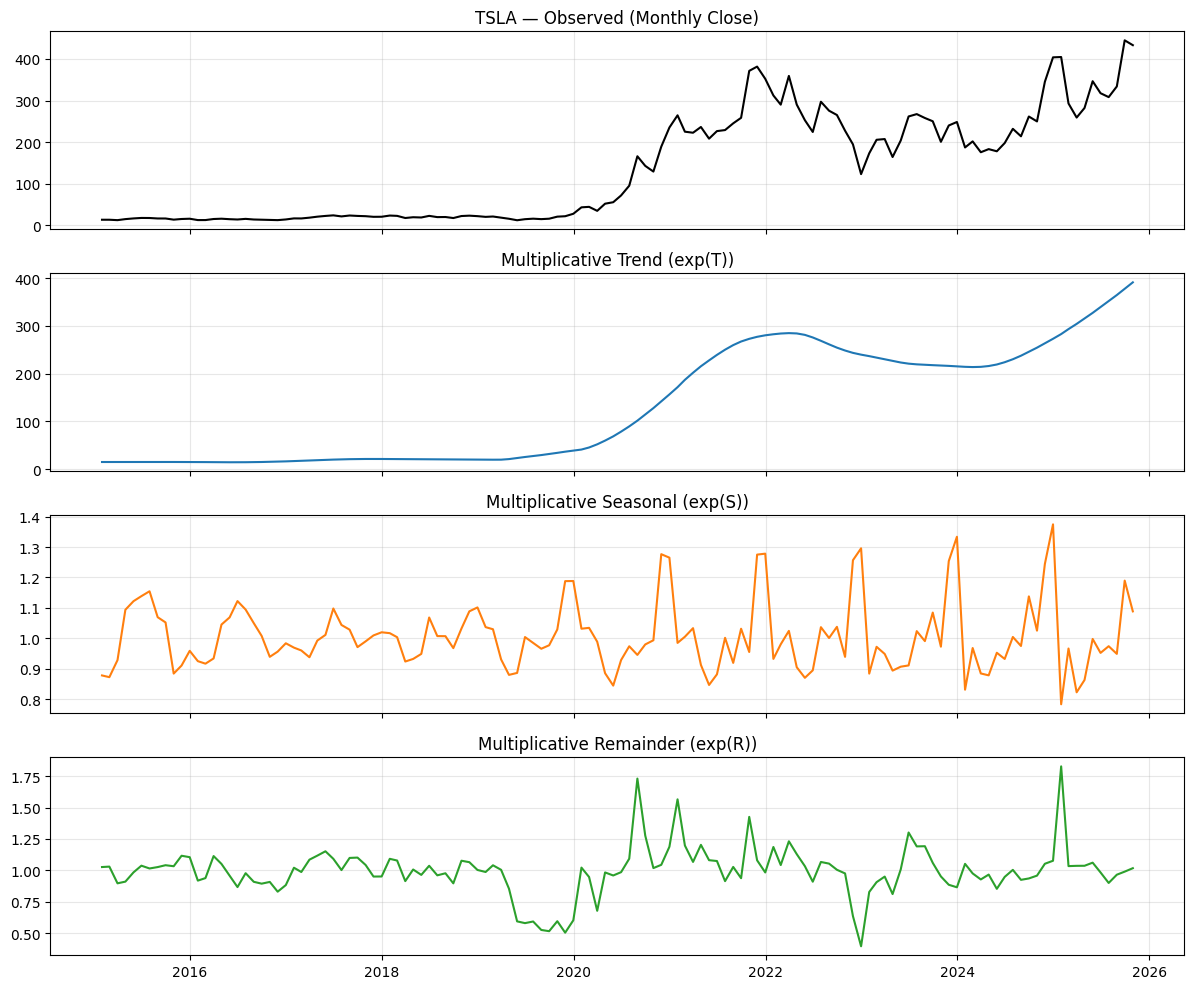

In [18]:
# ==============================================
# Colab 준비 (필요할 때만)
# ==============================================
# %pip -q install yfinance statsmodels

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

plt.rcParams["figure.figsize"] = (12, 5)

# ==============================================
# 1) 데이터 로드 & 월말 집계
# ==============================================
symbol     = "TSLA"
start_date = "2015-01-01"
end_date   = None  # 최신까지

# auto_adjust=True로 배당/분할 조정 종가 사용 + 경고 방지
px_d = yf.download(symbol, start=start_date, end=end_date, auto_adjust=True)
px_d.index = pd.to_datetime(px_d.index)

# 월말(MonthEnd) 종가로 집계
px_m = px_d.resample("ME").last().dropna()
y = px_m["Close"].astype(float).copy()
y.name = "close"

print(f"{symbol}: {len(y)} obs | {y.index[0].date()} ~ {y.index[-1].date()}")

# ==============================================
# 2) STL 분해 (가법 / 승법)
# ==============================================
PERIOD = 12  # 월별 계절주기

# --- (A) 가법 모델: y = Trend + Seasonal + Remainder
stl_add = STL(y, period=PERIOD, robust=True).fit()

# --- (B) 승법 모델(로그로 가법화): log(y) = T + S + R  ⇒
#       y = exp(T) * exp(S) * exp(R)
eps = 0.0  # y가 양수이므로 0이면 충분. (만약 0/음수 가능 데이터면 작은 eps 추가)
y_log = np.log(y + eps)
stl_mul = STL(y_log, period=PERIOD, robust=True).fit()

trend_m = np.exp(stl_mul.trend)
season_m = np.exp(stl_mul.seasonal)
remainder_m = np.exp(stl_mul.resid)
y_recon_multiplicative = trend_m * season_m * remainder_m  # 복원 체크용

# 복원 오차 확인(수치 오차 허용)
recon_err = float(np.nanmean(np.abs((y - y_recon_multiplicative) / y))) * 100
print(f"[Multiplicative] 재구성 상대오차(평균 |y - T*S*R| / y): {recon_err:.6f}%")

# ==============================================
# 3) 시각화
# ==============================================

# ---- (A) 가법 STL
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
axes[0].plot(y.index, y.values, color="black"); axes[0].set_title(f"{symbol} — Observed (Monthly Close)")
axes[1].plot(y.index, stl_add.trend, color="tab:blue"); axes[1].set_title("Additive Trend")
axes[2].plot(y.index, stl_add.seasonal, color="tab:orange"); axes[2].set_title("Additive Seasonal")
axes[3].plot(y.index, stl_add.resid, color="tab:green"); axes[3].set_title("Additive Remainder")
for ax in axes: ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# ---- (B) 승법 STL (로그 기반 → 원척도로 표시)
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
axes[0].plot(y.index, y.values, color="black"); axes[0].set_title(f"{symbol} — Observed (Monthly Close)")
axes[1].plot(y.index, trend_m, color="tab:blue"); axes[1].set_title("Multiplicative Trend (exp(T))")
axes[2].plot(y.index, season_m, color="tab:orange"); axes[2].set_title("Multiplicative Seasonal (exp(S))")
axes[3].plot(y.index, remainder_m, color="tab:green"); axes[3].set_title("Multiplicative Remainder (exp(R))")
for ax in axes: ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# ==============================================
# 4) 계절조정(series) 비교 (선택)
#    - 가법: y_sa_add = y - Seasonal
#    - 승법: y_sa_mul = y / Seasonal
# ==============================================
#y_sa_add = y - stl_add.seasonal
#y_sa_mul = y / season_m

#plt.figure(figsize=(12,5))
#plt.plot(y.index, y.values, label="Observed", color="black")
#plt.plot(y.index, y_sa_add, label="Seasonally Adjusted (Additive)", linestyle="--")
#plt.plot(y.index, y_sa_mul, label="Seasonally Adjusted (Multiplicative)", linestyle=":")
#plt.plot(y.index, y_sa_add, linestyle="--")
#plt.plot(y.index, y_sa_mul, linestyle=":")
#plt.title(f"{symbol} — Seasonally Adjusted (Additive vs Multiplicative)")
#plt.xlabel("Date"); plt.ylabel("Price")
#plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()
